# Rock-Paper-Scissors
Training a CNN on rock-paper-scissors hand images to build a simple game application

In [17]:
# import modules -----------------------------------------------------------------------------------
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
from keras import callbacks
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import InputLayer, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# define paths -------------------------------------------------------------------------------------
train_folder = 'dataset/train'
test_folder = 'dataset/test'
validation_folder = 'dataset/validation'

# Helper methods -----------------------------------------------------------------------------------
def load_image(img_path: str) -> np.ndarray:
    '''Load an image from a file path and return it as a numpy array.'''
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

def display_image(image: np.ndarray) -> None:
    '''Display an image in a matplotlib window.'''
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def save_rps_model(model: Sequential, name: str) -> None:
    '''Save a model to a file with a timestamped filename.'''
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    filename = f'models/{name}_{timestamp}.h5'
    model.save(filename)

def load_rps_model(path: str = None):
    '''Load a model from a file path. If no path is provided, the latest model is loaded.'''

    if not path:
        # load latest version
        path = os.path.join('models', sorted([m for m in os.listdir('models') if m.lower().endswith('.h5')])[-1])

    model = load_model(path)
    input_shape = model.layers[0].input_shape

    print(f'Loaded model: {path} with input shape: {input_shape}')
    return model


## Check dataset content

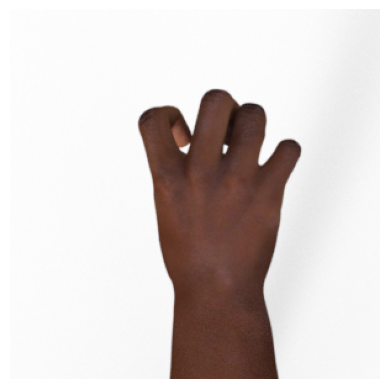

In [18]:
# open test picture
rock_folder = 'dataset/train/rock'
test_image = random.choice(os.listdir(rock_folder))
image_path = os.path.join(rock_folder, test_image)
img = load_image(image_path)
display_image(img)

## Preparing data for the model

In [19]:
image_shape = (150, 150, 3)
batch_size = 32

image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,  # True if you plan to show your hand upside down
    fill_mode='nearest'
)

train_image_gen = image_gen.flow_from_directory(
    train_folder,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # enable shuffling to make the model more robust
)

test_image_gen = image_gen.flow_from_directory(
    test_folder,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # disable shuffling to keep data in same order as labels
)

validation_generator = image_gen.flow_from_directory(
        validation_folder,
        target_size=image_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False)  # disable shuffling to keep data in same order as labels

Found 6234 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 787 images belonging to 3 classes.


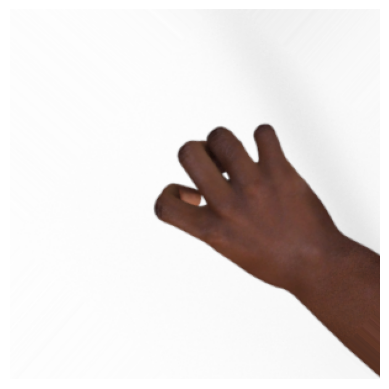

In [20]:
# test generator on random image
random_img = image_gen.random_transform(img)
display_image(random_img)

## Create Model

In [21]:
# create sequential modle
model = Sequential()

model.add(InputLayer(input_shape=image_shape))

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))

# Add 50% dropout to help reduce overfitting
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=3, activation='softmax'))  # 3 classes

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

## Moving the model to GPU
WIP, I currently cannot see my GPU listed here

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16162169706054385380
xla_global_id: -1
]


## Training Model

In [23]:
# indices
class_indices = train_image_gen.class_indices
class_labels = {v:k for k, v in class_indices.items()}
print(class_indices)
print(class_labels)

{'paper': 0, 'rock': 1, 'scissors': 2}
{0: 'paper', 1: 'rock', 2: 'scissors'}


In [24]:
# Initializing early stopping callback to monitor the validation loss and prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor="accuracy",
                                        mode="max",
                                        patience=5,
                                        restore_best_weights=True)

In [25]:
# Train the model
results = model.fit(
    train_image_gen,
    epochs=100,
    steps_per_epoch=train_image_gen.samples/train_image_gen.batch_size,
    validation_data=test_image_gen,
    validation_steps=test_image_gen.samples/test_image_gen.batch_size,
    verbose=2,
    callbacks=[earlystopping]
    )

Epoch 1/100
194/194 - 65s - loss: 1.1312 - accuracy: 0.3657 - val_loss: 1.0753 - val_accuracy: 0.3892 - 65s/epoch - 335ms/step
Epoch 2/100
194/194 - 63s - loss: 1.0056 - accuracy: 0.4658 - val_loss: 0.9084 - val_accuracy: 0.5580 - 63s/epoch - 323ms/step
Epoch 3/100
194/194 - 63s - loss: 0.8224 - accuracy: 0.6142 - val_loss: 0.6363 - val_accuracy: 0.7436 - 63s/epoch - 323ms/step
Epoch 4/100
194/194 - 63s - loss: 0.6323 - accuracy: 0.7273 - val_loss: 0.6988 - val_accuracy: 0.6714 - 63s/epoch - 322ms/step
Epoch 5/100
194/194 - 63s - loss: 0.5170 - accuracy: 0.7902 - val_loss: 0.3535 - val_accuracy: 0.8814 - 63s/epoch - 323ms/step
Epoch 6/100
194/194 - 63s - loss: 0.4124 - accuracy: 0.8396 - val_loss: 0.3486 - val_accuracy: 0.8763 - 63s/epoch - 324ms/step
Epoch 7/100
194/194 - 63s - loss: 0.3548 - accuracy: 0.8661 - val_loss: 0.3042 - val_accuracy: 0.8802 - 63s/epoch - 324ms/step
Epoch 8/100
194/194 - 63s - loss: 0.3505 - accuracy: 0.8696 - val_loss: 0.3139 - val_accuracy: 0.8802 - 63s/epo

## Visualize Accuracy

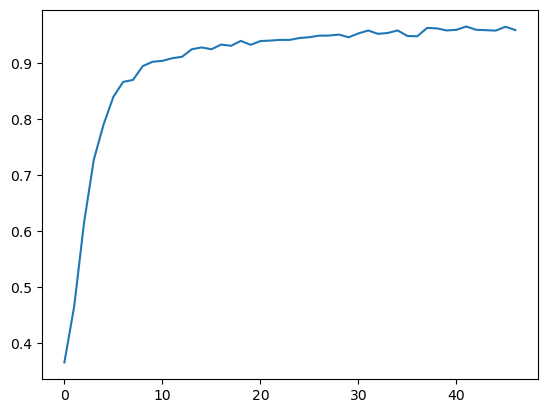

In [26]:
plt.plot(results.history['accuracy'])

## Save model

In [27]:
save_rps_model(model, 'rps_v07_47[epoch]_0.9585[acc]_0.1195[loss]')

## Confusion Matrix and Classification Report

In [28]:
model = load_rps_model()

validation_steps = len(validation_generator)
validation_generator.reset() # Reset the generator to be sure of avoiding shuffling

predictions = model.predict_generator(validation_generator, steps=validation_steps, verbose=1)
y_pred_classes = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(validation_generator.classes, y_pred_classes))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(validation_generator.classes, y_pred_classes))

Loaded model: models\rps_v06_56[epoch]_0.9641[acc]_0.1089[loss]_20240221_1825.h5 with input shape: (None, 150, 150, 3)
25/25 [==============================] - 4s 166ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       261
           1       0.97      0.99      0.98       263
           2       0.98      0.97      0.97       263

    accuracy                           0.97       787
   macro avg       0.97      0.97      0.97       787
weighted avg       0.97      0.97      0.97       787

Confusion Matrix:
[[251   4   6]
 [  2 261   0]
 [  5   4 254]]


## Image prediction Test

Loaded model: models\rps_v06_56[epoch]_0.9641[acc]_0.1089[loss]_20240221_1825.h5 with input shape: (None, 150, 150, 3)


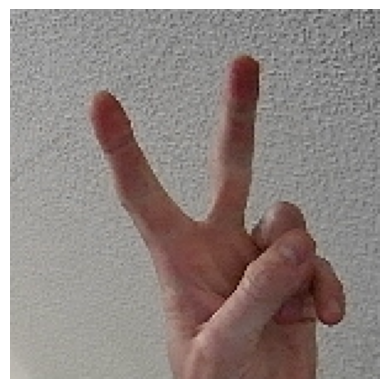

prediction_prob:  ['paper: 0.012521731667220592', 'rock: 0.2810622453689575', 'scissors: 0.7064160704612732']
predicted_class_index: 2
predicted_class_label: scissors
predicted_class_prob: 0.7064161


In [29]:
model = load_rps_model()
input_model_size = model.layers[0].input_shape[1:3]

class_indices = {'paper': 0, 'rock': 1, 'scissors': 2}
class_labels = {v:k for k, v in class_indices.items()}

img_file = os.path.join('test', random.choice(os.listdir('test')))
img = image.load_img(img_file, target_size=input_model_size)
display_image(img)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255

prediction_prob = model.predict(img, verbose=0)[0]
predicted_class_index = np.argmax(prediction_prob)
predicted_class_label = class_labels[predicted_class_index]
predicted_class_prob = prediction_prob[predicted_class_index]

print('prediction_prob: ', [f'{k}: {prediction_prob[v]}' for k, v in class_indices.items()])
print('predicted_class_index:', predicted_class_index)
print('predicted_class_label:', predicted_class_label)
print('predicted_class_prob:', predicted_class_prob)

## Classify Validation Pictures
Run all validation pictures through the model and classify them. Display the failed ones.

Loaded model: models\rps_v06_56[epoch]_0.9641[acc]_0.1089[loss]_20240221_1825.h5 with input shape: (None, 150, 150, 3)
Images Classified: 787 | Success: 774 | Failure: 13 | Accuracy: 98.35%                                  
--------------------------------------------------
FAILED IMAGES:
dataset\validation\paper\paper_alexdjulin_validation_108.png


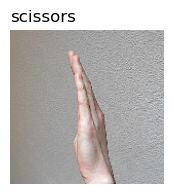

dataset\validation\paper\paper_alexdjulin_validation_117.png


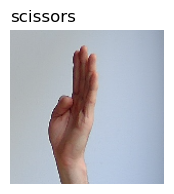

dataset\validation\paper\paper_alexdjulin_validation_119.png


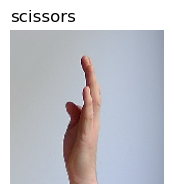

dataset\validation\paper\paper_alexdjulin_validation_153.png


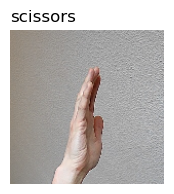

dataset\validation\paper\paper_alexdjulin_validation_158.png


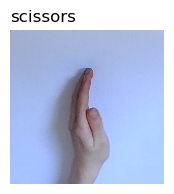

dataset\validation\paper\paper_alexdjulin_validation_180.png


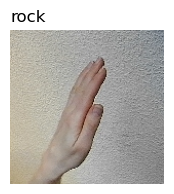

dataset\validation\paper\paper_alexdjulin_validation_181.png


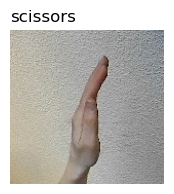

dataset\validation\paper\paper_drgfreeman_validation_373.png


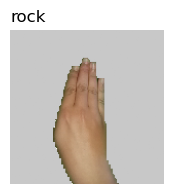

dataset\validation\paper\paper_drgfreeman_validation_375.png


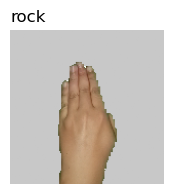

dataset\validation\paper\paper_drgfreeman_validation_418.png


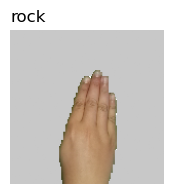

dataset\validation\scissors\scissors_alexdjulin_validation_205.png


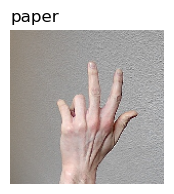

dataset\validation\scissors\scissors_alexdjulin_validation_259.png


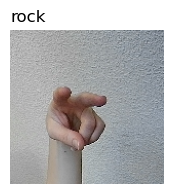

dataset\validation\scissors\scissors_alexdjulin_validation_274.png


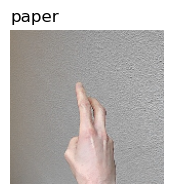

In [30]:
model = load_rps_model()
input_model_size = model.layers[0].input_shape[1:3]

success = 0
failure = 0
total = 0
failed_images = []

# load model
class_indices = {'paper': 0, 'rock': 1, 'scissors': 2}
class_labels = {v:k for k, v in class_indices.items()}

test_images = None  # limit number of images to test if needed, None to go through all of them
idx = 0

for subfolder in ['rock', 'paper', 'scissors']:

    current_folder = os.path.join(validation_folder, subfolder)

    for img_name in os.listdir(current_folder):

        if test_images is not None and idx > test_images - 1:
            break
        idx += 1

        img_file = os.path.normpath(os.path.join(current_folder, img_name))

        roi_copy = image.load_img(img_file, target_size=input_model_size)
        img_array = image.img_to_array(roi_copy)

        # add batch dimension
        img_normalized = img_array/255
        img_expanded = np.expand_dims(img_normalized, axis=0)

        # image prediction probability
        prediction_prob = model.predict(img_expanded, verbose=0)

        # Get predicted class index
        predicted_class_index = np.argmax(prediction_prob)

        # Map predicted class index to class label
        predicted_class_label = class_labels[predicted_class_index]

        # Print predicted class label
        if subfolder == predicted_class_label:
            success += 1
            result = 'success'
        else:
            failure += 1
            result = 'failure'
            failed_images.append((img_normalized, predicted_class_label, img_file))

        total += 1
        to_print = f'\rImages Classified: {total} | Success: {success} | Failure: {failure} | Accuracy: {success/total*100:.2f}%'
        print(f'{to_print:<100}', end=' ', flush=True)

# print failed images with prediction and path
if failed_images:
    print(f"\n{50 * '-'}\nFAILED IMAGES:")
    for roi_copy, label, path in failed_images:
        print(path)
        img_size = 200
        plt.figure(figsize=(img_size/100, img_size/100))
        plt.imshow(roi_copy, cmap='gray')
        plt.title(label, loc='left')
        plt.axis('off')
        plt.show()

## Test on camera
Define a ROI from webcam frames and predict the class.

In [16]:
model = load_rps_model()
input_model_size = model.layers[0].input_shape[1:3]

class_labels = {0: 'paper', 1: 'rock', 2: 'scissors'}

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cv2.namedWindow('Rock Paper Scissors')

# define ROI position and size
x, y, w, h = 895, 78, 300, 300

while True:

    try:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        roi = frame[y:y+h, x:x+w]

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

        # convert roi to RGB, resize and normalize
        roi_resized = cv2.resize(roi, input_model_size, interpolation=cv2.INTER_AREA)
        roi_rgb = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2RGB)
        roi_normalized = roi_rgb / 255.0
        roi_expanded = np.expand_dims(roi_normalized, axis=0)

        # Classify the ROI image
        prediction_prob = model.predict(roi_expanded, verbose=0)[0]
        predicted_class_index = np.argmax(prediction_prob)
        predicted_class_label = class_labels[predicted_class_index]
        predicted_class_prob = prediction_prob[predicted_class_index]

        # display captured roi top left of the frame for debugging
        frame[0:input_model_size[0], 0:input_model_size[1]] = roi_resized

        # Display prediction
        if predicted_class_prob < 0.9:
            label = 'Undefined'
        else:
            label = f'{predicted_class_label} ({predicted_class_prob:.2f})'

        p_paper, p_rock, p_scissors = (f'{p:.2f}' for p in prediction_prob)
        print(f'Prediction: Rock {p_rock} - Paper {p_paper} - Scissors {p_scissors}', end='\r')

        # Draw label
        position = x, y + h + 20
        color = 0, 0, 255
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

        # Display frame
        cv2.imshow('Rock Paper Scissors', frame)

    except Exception as e:
        print(e)
        break

cap.release()
cv2.destroyAllWindows()

Loaded model: models\rps_v06_56[epoch]_0.9641[acc]_0.1089[loss]_20240221_1709.h5 with input shape: (None, 150, 150, 3)
